<a href="https://colab.research.google.com/github/applepi17618/MTS_Gen_AI_course/blob/main/cgan_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

При тренировке CGAN был использован датасет Kuzushiji-MNIST (https://www.kaggle.com/datasets/anokas/kuzushiji), содержащий изображения с письменным обозначением слогов в японской хирагана. Датасет содержит около 270 тысяч изображений, разбитых 49 классов, обозначающих различные начертаниями из хирагана. К сожалению, большой объём данных, а также слабая мощность имеющегося устройства позволили пробежать только одну тренировочную эпоху, которая длилась 7 часов, поэтому многие результаты или оказались спорными и неочевидными, или же вовсе не были достигнуты. Данные при обучении аугментации не подвергались. Была использована уже предложенная архитектура CGAN из ноутбука с курса.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision
import torch

In [3]:
random_seed = 42

In [4]:
#Загружаем датасет.

train_imgs = np.load('/content/drive/MyDrive/dataset/k49-train-imgs.npz')['arr_0']
test_imgs = np.load('/content/drive/MyDrive/dataset/k49-test-imgs.npz')['arr_0']
train_labels = np.load('/content/drive/MyDrive/dataset/k49-train-labels.npz')['arr_0']
test_labels = np.load('/content/drive/MyDrive/dataset/k49-test-labels.npz')['arr_0']

#Нормализуем то, что загрузили.

train_imgs = (train_imgs.astype(np.float32) / 127.5) - 1
test_imgs = (test_imgs.astype(np.float32) / 127.5) - 1

#Преобразуем np-arrays в PyTorch тензоры.

train_imgs = torch.tensor(train_imgs).unsqueeze(1)
test_imgs = torch.tensor(test_imgs).unsqueeze(1)

train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

In [5]:
#Создаём класс для датасета.

from torch.utils.data import DataLoader, Dataset

class Kanji_Dataset(Dataset):
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    return self.images[idx], self.labels[idx]

In [6]:
#Применяем класс к датасету.

train_dataset = Kanji_Dataset(train_imgs, train_labels)
test_dataset = Kanji_Dataset(test_imgs, test_labels)

In [7]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

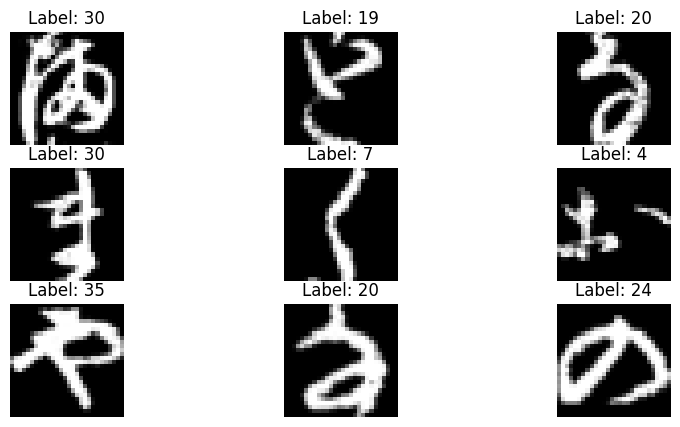

In [8]:
#Визуализируем данные.
plt.figure(figsize=(10,5))
for i in range(9):
  img, label = train_dataset[i]
  plt.subplot(3, 3, i + 1)
  plt.imshow(img.squeeze(0), cmap='gray')
  plt.title(f'Label: {label.item()}')
  plt.axis('off')
plt.show()

In [9]:
device = torch.device('cpu')
print(device)

cpu


In [10]:
import torch.nn as nn

In [4]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=49):
        super(ConditionalGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.label_emb = nn.Embedding(num_classes, num_classes)  # Преобразование метки в плотное представление
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + num_classes, 128, 7, stride=1, padding=0),  # (latent_dim + num_classes, 1, 1) -> (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # (128, 7, 7) -> (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1),  # (64, 14, 14) -> (1, 28, 28)
            nn.Tanh()  # Вывод в диапазоне [-1, 1]
        )
    def forward(self, z, labels):
        labels = self.label_emb(labels)  # Преобразование меток в эмбеддинги
        labels = labels.view(-1, self.num_classes, 1, 1)
        z = z.view(-1, self.latent_dim, 1, 1)
        input = torch.cat([z, labels], dim=1)  # Объединение шума и меток
        return self.model(input)


In [5]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=49):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Conv2d(1 + num_classes, 64, 4, stride=2, padding=1),  # (1 + num_classes, 28, 28) -> (64, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # (64, 14, 14) -> (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 7, stride=1, padding=0),  # (128, 7, 7) -> (1, 1, 1)
            nn.Sigmoid()  # Вероятность реальности
        )

    def forward(self, img, labels):
        labels = self.label_emb(labels)
        labels = labels.view(-1, num_classes, 1, 1)
        labels = labels.expand(-1, -1, img.size(2), img.size(3))  # Расширение меток до размера изображения
        input = torch.cat([img, labels], dim=1)  # Объединение изображения и меток
        return self.model(input)

In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),  # (1, 28, 28) -> (32, 28, 28)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # (32, 28, 28) -> (32, 14, 14)
            nn.Conv2d(32, 64, 3, stride=1, padding=1),  # (32, 14, 14) -> (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # (64, 14, 14) -> (64, 7, 7)
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 49),  # (64*7*7) -> (10)
            nn.Softmax(dim=1)  # Вероятности для 10 классов
        )

    def forward(self, x):
        return self.model(x)

In [18]:
import json



def save_params(model, epoch, loss, filename):
    params = {
        "epoch": epoch,
        "loss": loss,
        "model_state": {k: v.tolist() for k, v in model.state_dict().items()}
    }
    with open(filename, "w") as f:
        json.dump(params, f)

In [14]:
classifier_learning_rate = 0.0001
classifier_batch_size = 32
classifier_epochs = 20

In [15]:
import torch.optim as optim

In [19]:
classifier = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=classifier_learning_rate)
classifier_losses = []

for epoch in range(classifier_epochs):
  classifier.train()
  running_loss = 0.0
  for img, label in train_loader:
    img, label = img.to(device), label.to(device)

    optimizer.zero_grad()
    outputs = classifier(img)
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f'Epoch: {epoch+1}, Loss: {running_loss/len(train_loader)}')
  avg_loss = running_loss/len(train_loader)
  classifier_losses.append(avg_loss)

  save_params(classifier, epoch+1, running_loss, f"classifier_params_epoch_{epoch+1}.json")

torch.save(classifier.state_dict(), 'classifier.pth')

Epoch: 1, Loss: 3.260439352797464
Epoch: 2, Loss: 3.1681584114543795
Epoch: 3, Loss: 3.152608647815323
Epoch: 4, Loss: 3.143494988991452
Epoch: 5, Loss: 3.133480074319653
Epoch: 6, Loss: 3.1209015869890746
Epoch: 7, Loss: 3.1169080697810543
Epoch: 8, Loss: 3.1136853722165485
Epoch: 9, Loss: 3.110934851419758
Epoch: 10, Loss: 3.0979600872293513
Epoch: 11, Loss: 3.094317590819348
Epoch: 12, Loss: 3.0920206719408743
Epoch: 13, Loss: 3.0802877961489425
Epoch: 14, Loss: 3.0744989942959338
Epoch: 15, Loss: 3.0687993991411084
Epoch: 16, Loss: 3.066827816925112
Epoch: 17, Loss: 3.065545314174485
Epoch: 18, Loss: 3.064321015892985
Epoch: 19, Loss: 3.0633297079819615
Epoch: 20, Loss: 3.0624889528675863


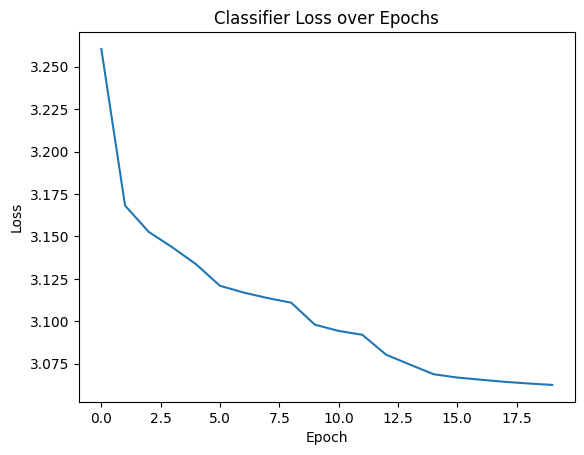

In [20]:
plt.plot(classifier_losses)
plt.title('Classifier Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('Classifier_Loss.png')
plt.show()

In [38]:
#Зададим параметры обучения, оптимизаторы и функцию потерь.
latent_dim = 100
num_classes = 49
generator = ConditionalGenerator(latent_dim=latent_dim, num_classes=num_classes)
discriminator = ConditionalDiscriminator(num_classes=num_classes)

discriminator_learning_rate = 0.001
generator_learning_rate = 0.001
cgan_epochs = 1
cgan_batch_size = 64

d_optimizer = optim.Adam(discriminator.parameters(),lr=discriminator_learning_rate, betas=(0.5,0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=generator_learning_rate, betas=(0.5, 0.999))

loss = nn.BCELoss()

In [39]:
d_losses, g_losses = [], []
for epoch in range(cgan_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        batch_size = imgs.size(0)

        # Метки для реальных и фейковых данных
        real_label = torch.ones(batch_size, 1, 1, 1)
        fake_label = torch.zeros(batch_size, 1, 1, 1)

        # Обучение дискриминатора
        d_optimizer.zero_grad()
        real_output = discriminator(imgs, labels)
        d_real_loss = loss(real_output, real_label)

        z = torch.randn(batch_size, latent_dim, 1, 1)
        z = z.to(device)

        fake_labels = torch.randint(0, num_classes, (batch_size,))
        fake_labels = fake_labels.to(device)
        fake_imgs = generator(z, fake_labels)
        fake_output = discriminator(fake_imgs.detach(), fake_labels)
        d_fake_loss = loss(fake_output, fake_label)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        # Обучение генератора
        g_optimizer.zero_grad()
        fake_output = discriminator(fake_imgs, fake_labels)
        g_loss = loss(fake_output, real_label)

        g_loss.backward()
        g_optimizer.step()

        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{cgan_epochs}] Batch [{i}/{len(train_loader)}] '
                  f'D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}')

            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

        save_params(generator, epoch+1, g_loss.tolist(), f"generator_params_epoch_{epoch+1}.json")
        save_params(discriminator, epoch+1, d_loss.tolist(), f"discriminator_params_epoch_{epoch+1}.json")

# Сохранение моделей
torch.save(generator.state_dict(), f'conditional_generator.pth')
torch.save(discriminator.state_dict(), f'conditional_discriminator.pth')

Epoch [1/1] Batch [0/7262] D Loss: 1.4677 G Loss: 2.0831
Epoch [1/1] Batch [100/7262] D Loss: 1.6432 G Loss: 0.5110
Epoch [1/1] Batch [200/7262] D Loss: 0.6537 G Loss: 1.7052
Epoch [1/1] Batch [300/7262] D Loss: 0.0782 G Loss: 3.4705
Epoch [1/1] Batch [400/7262] D Loss: 0.3007 G Loss: 1.5761
Epoch [1/1] Batch [500/7262] D Loss: 0.0185 G Loss: 3.6134
Epoch [1/1] Batch [600/7262] D Loss: 0.0055 G Loss: 5.9064
Epoch [1/1] Batch [700/7262] D Loss: 0.0786 G Loss: 2.8770
Epoch [1/1] Batch [800/7262] D Loss: 3.8217 G Loss: 0.1573
Epoch [1/1] Batch [900/7262] D Loss: 0.5158 G Loss: 2.5867
Epoch [1/1] Batch [1000/7262] D Loss: 1.8066 G Loss: 0.4359
Epoch [1/1] Batch [1100/7262] D Loss: 1.6855 G Loss: 3.7138
Epoch [1/1] Batch [1200/7262] D Loss: 0.5068 G Loss: 1.2916
Epoch [1/1] Batch [1300/7262] D Loss: 0.1399 G Loss: 2.4903
Epoch [1/1] Batch [1400/7262] D Loss: 0.8708 G Loss: 1.5971
Epoch [1/1] Batch [1500/7262] D Loss: 0.0020 G Loss: 6.5577
Epoch [1/1] Batch [1600/7262] D Loss: 0.2774 G Loss:

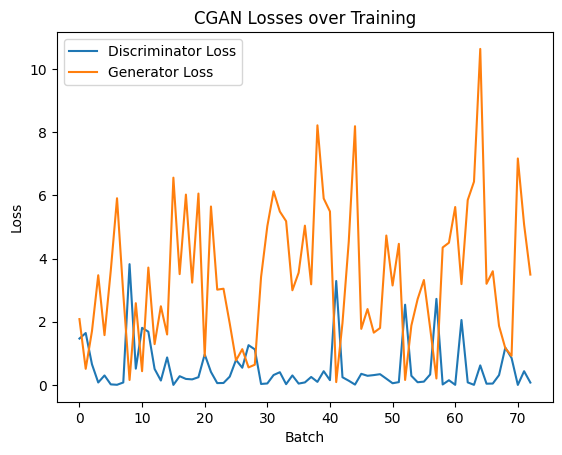

In [40]:
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('CGAN Losses over Training')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

К сожалению, лишь одна эпоха не смогла помочь добиться минимизации функции у генератора и её максимизации у дискриминатора.

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
classifier.eval()
preds, true_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        outputs = classifier(imgs)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.70      0.95      0.81      1000
           1       0.94      0.96      0.95      1000
           2       0.89      0.96      0.92      1000
           3       0.00      0.00      0.00       126
           4       0.68      0.95      0.79      1000
           5       0.85      0.63      0.72      1000
           6       0.86      0.77      0.81      1000
           7       0.79      0.91      0.85      1000
           8       0.76      0.63      0.69       767
           9       0.75      0.85      0.80      1000
          10       0.97      0.76      0.85      1000
          11       0.89      0.64      0.75      1000
          12       0.68      0.78      0.72      1000
          13       0.74      0.73      0.74       678
          14       0.00      0.00      0.00       629
          15       0.91      0.61      0.73      1000
          16       0.80      0.96      0.88       418
          17       0.77    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


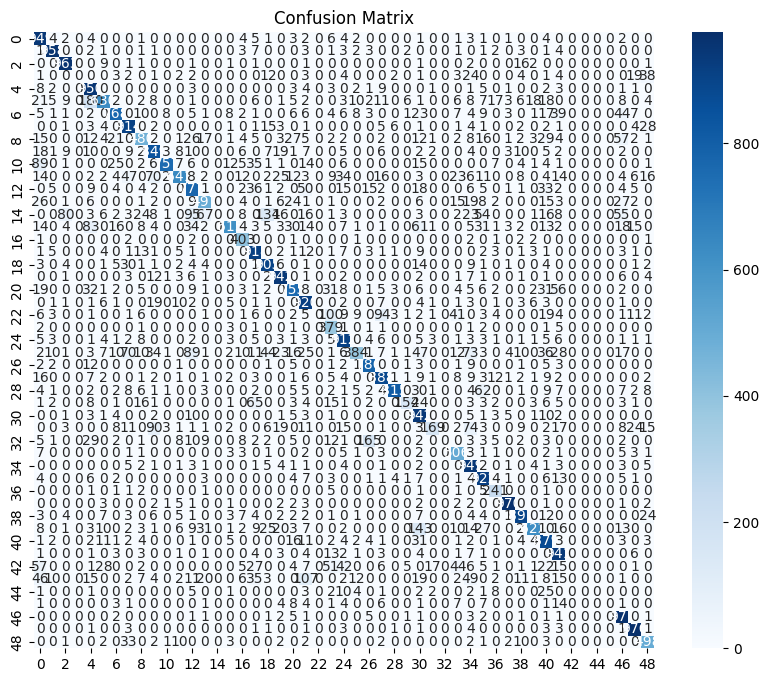

In [42]:
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

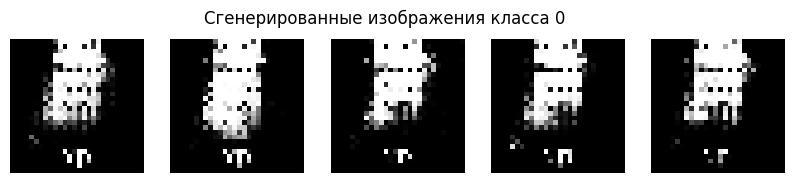

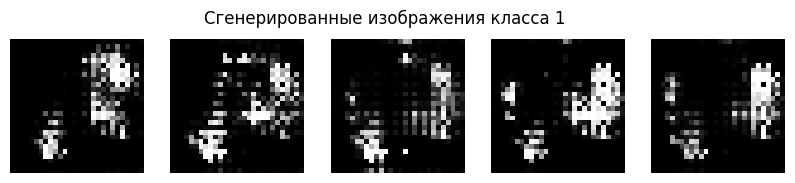

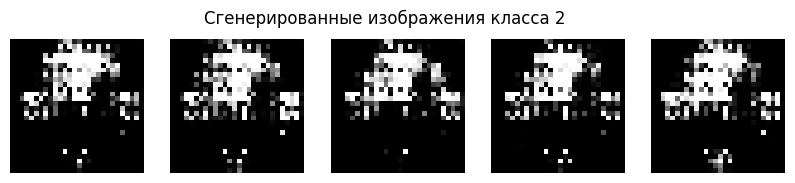

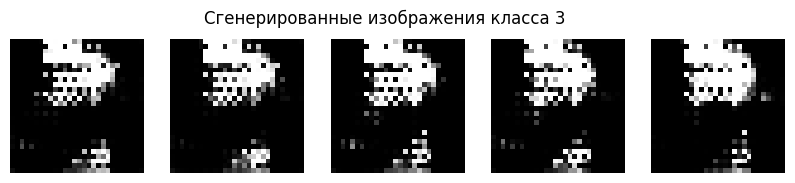

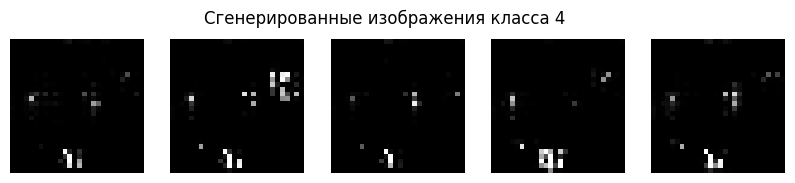

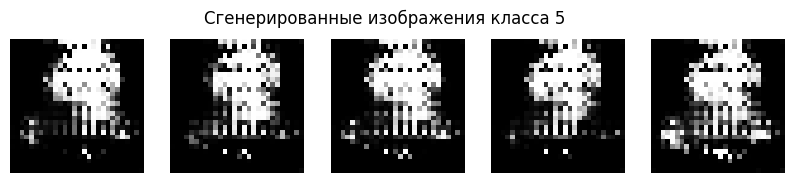

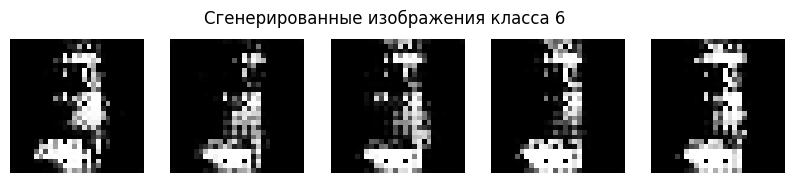

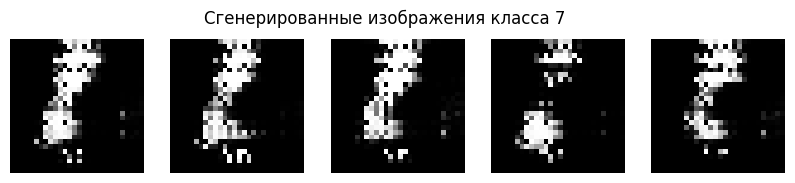

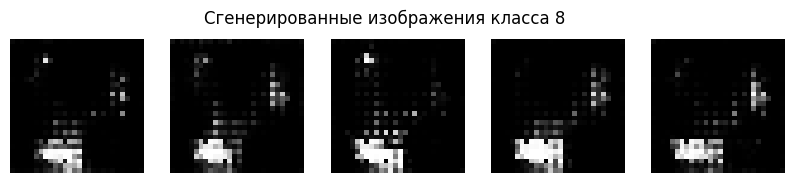

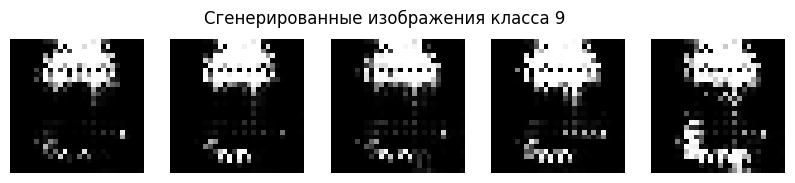

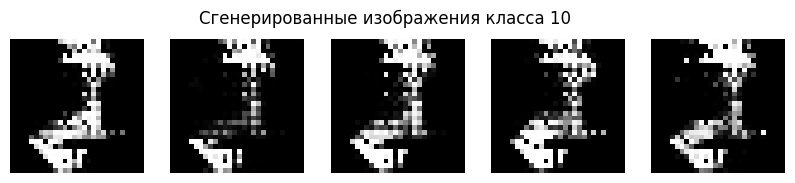

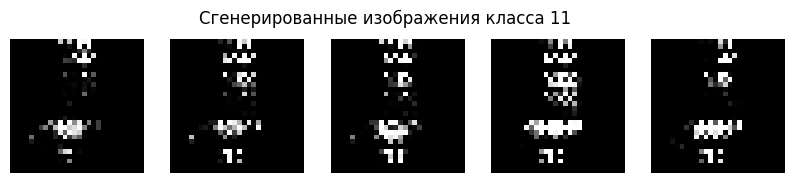

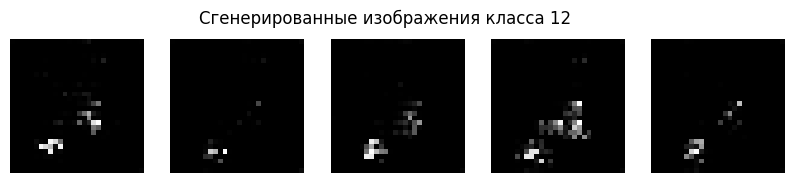

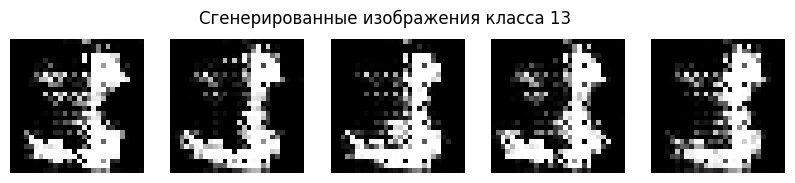

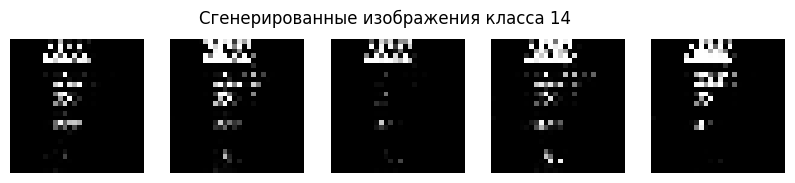

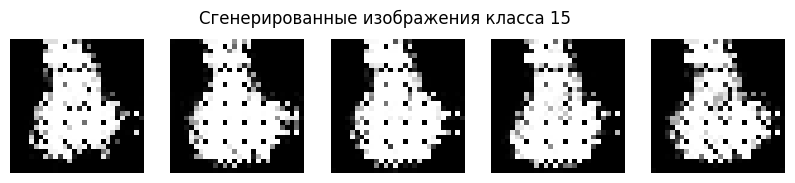

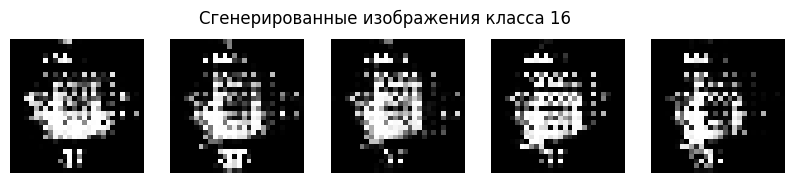

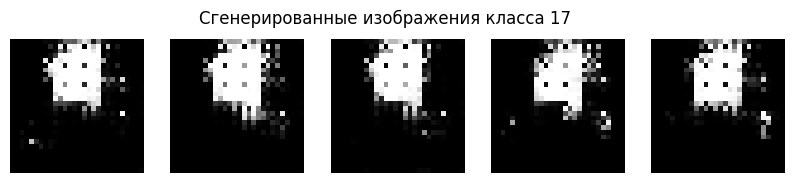

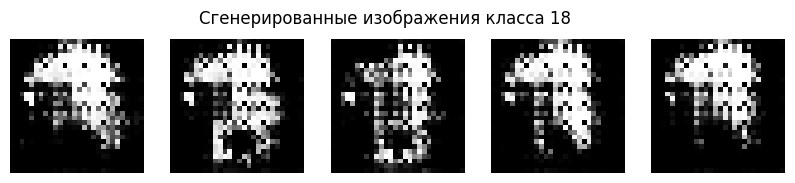

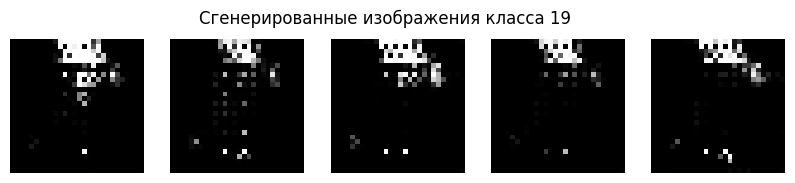

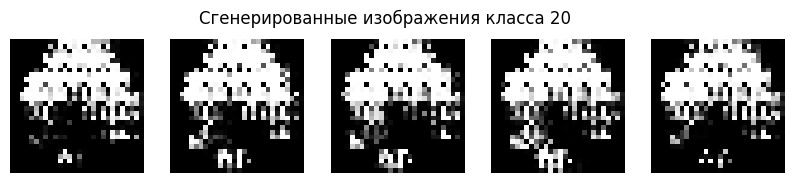

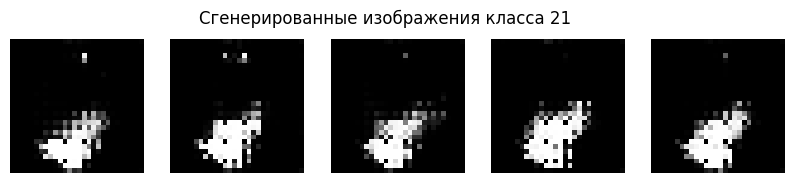

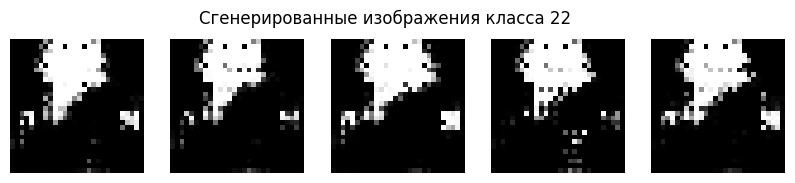

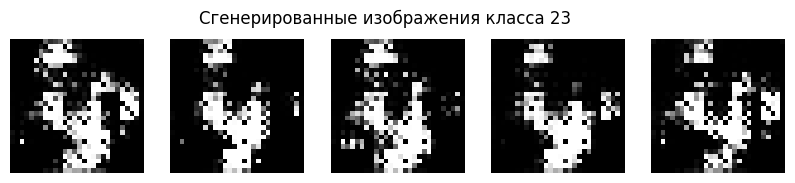

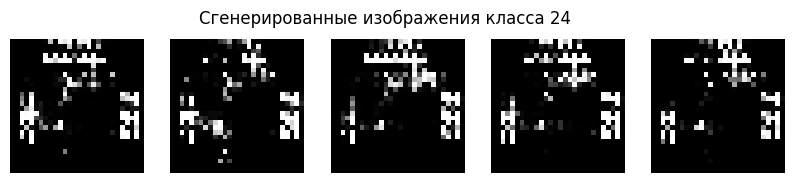

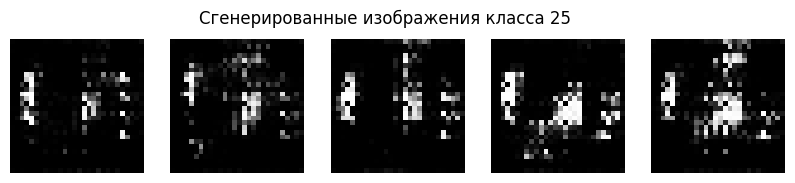

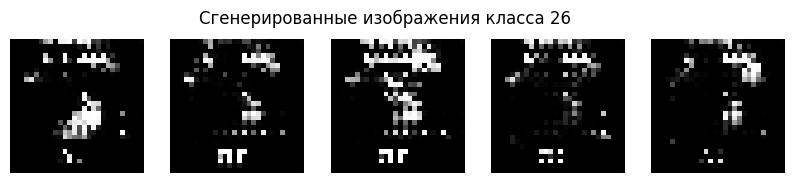

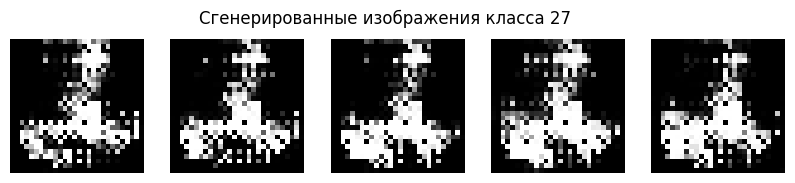

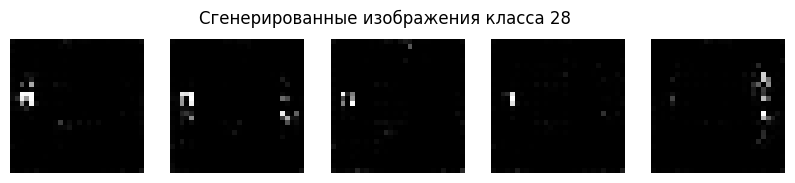

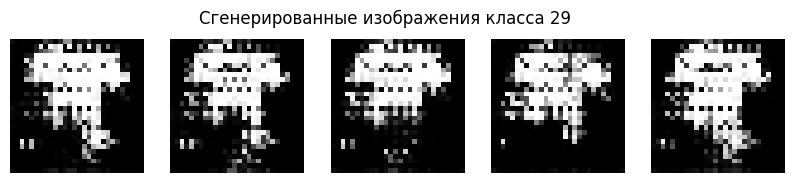

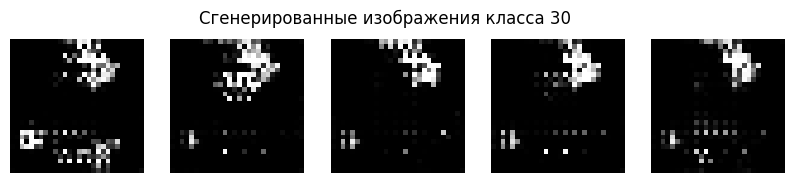

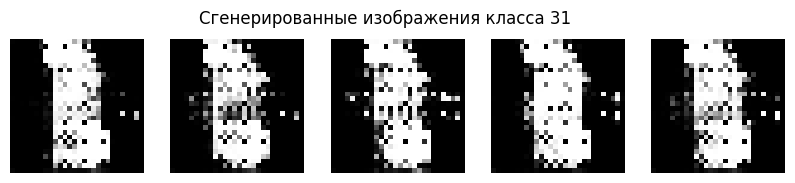

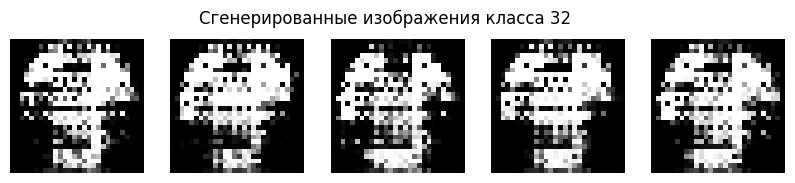

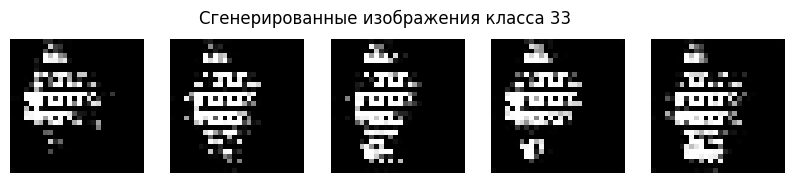

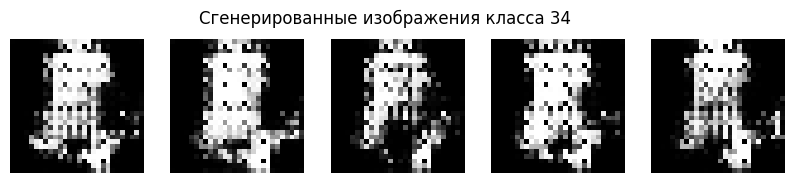

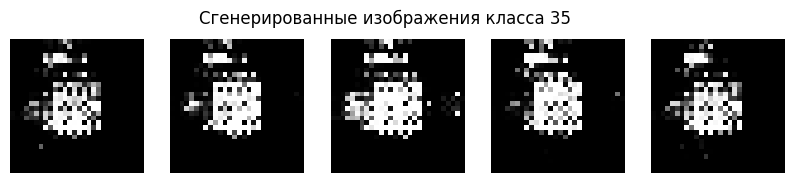

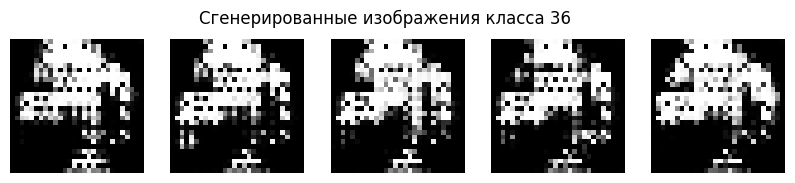

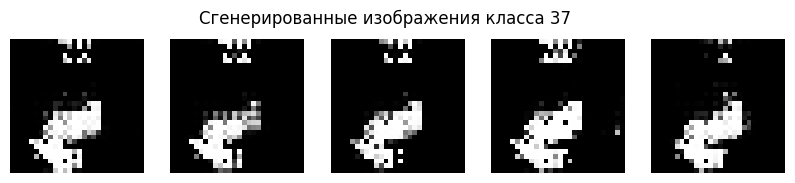

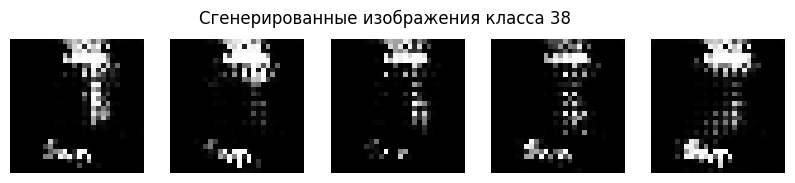

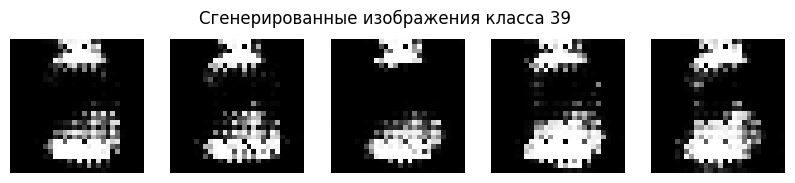

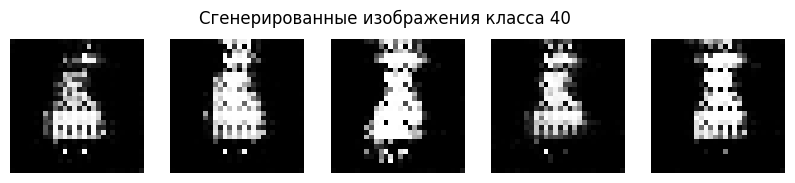

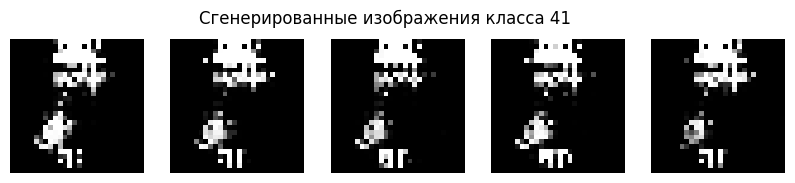

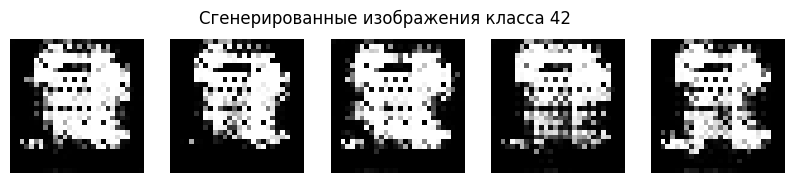

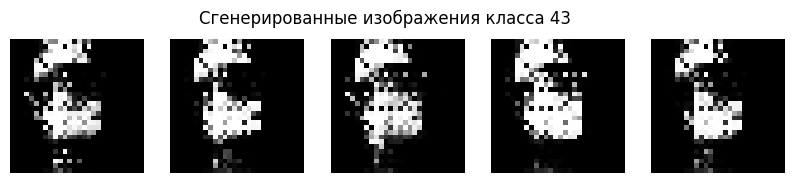

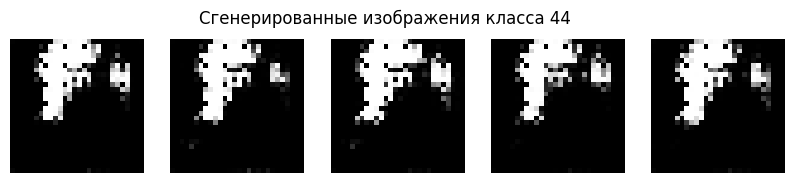

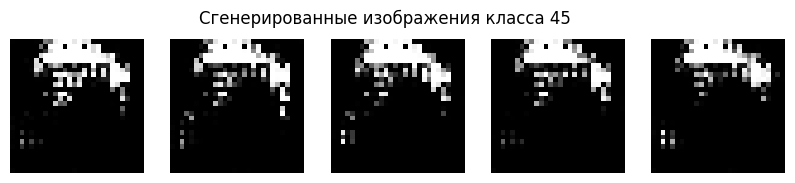

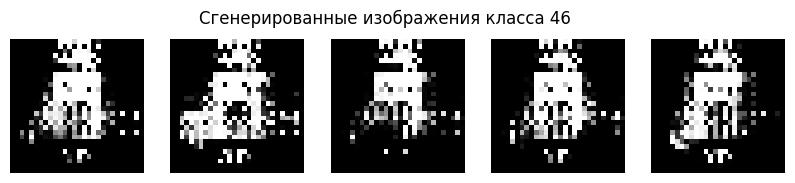

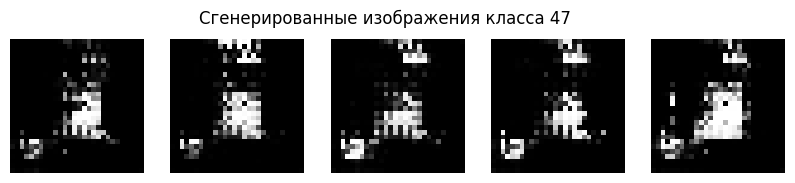

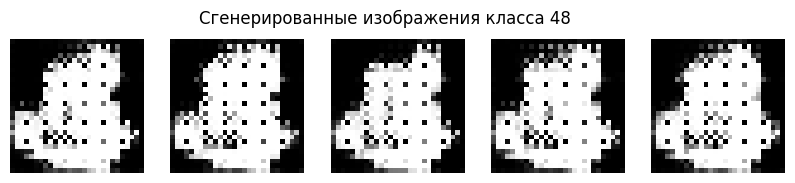

In [46]:
num_of_classes = 49
latent_dim = 100  # Укажите размерность латентного пространства

for i in range(num_of_classes):
    z = torch.randn(5, latent_dim, 1, 1)  # Генерируем случайный латентный вектор
    label = torch.full((5,), i, dtype=torch.long).to(device)  # Создаем метки классов

    generator.eval()
    with torch.no_grad():
        fake_imgs = generator(z, label).cpu()  # Генерируем изображения

    fig, axes = plt.subplots(1, 5, figsize=(10, 2))  # Создаем подграфики

    for j in range(5):  # Перебираем 5 изображений
        axes[j].imshow(fake_imgs[j].squeeze(0).numpy(), cmap='gray')  # Убираем 1-ю размерность
        axes[j].axis('off')

    plt.suptitle(f'Сгенерированные изображения класса {i}')
    plt.show()

In [47]:
classifier = Classifier()
classifier.load_state_dict(torch.load('classifier.pth'))

generator = ConditionalGenerator(latent_dim=latent_dim, num_classes=num_classes)
generator.load_state_dict(torch.load('conditional_generator.pth'))

discriminator = ConditionalDiscriminator(num_classes=num_classes)
discriminator.load_state_dict(torch.load('conditional_discriminator.pth'))

<ipython-input-47-e0cde63c60f0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load('classifier.pth'))
<ipython-input-47-e0cde63c60f0>:5: 

<All keys matched successfully>

Дискриминатор: 0.2061 (вероятность реальности)
Классификатор: Класс 6


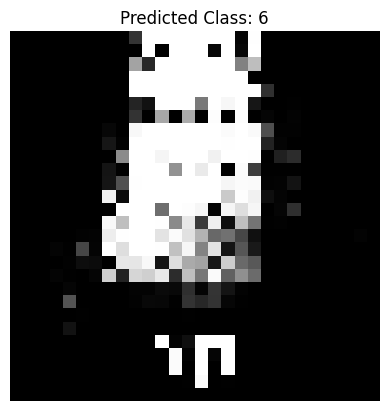

In [48]:
generator.eval()
discriminator.eval()
classifier.eval()

desired_class = 0
z = torch.randn(1, latent_dim, 1, 1)
label = torch.tensor([desired_class])

with torch.no_grad():
    generated_img = generator(z, label)
    disc_pred = discriminator(generated_img, label)
    print(f'Дискриминатор: {disc_pred.item():.4f} (вероятность реальности)')
    class_pred = classifier(generated_img)
    predicted_class = class_pred.argmax(dim=1).item()
    print(f'Классификатор: Класс {predicted_class}')
    plt.imshow(generated_img.squeeze().cpu(), cmap='gray')
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.savefig('inference_example_class_0.png')
    plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [7]:
generator = ConditionalGenerator()
discriminator = ConditionalDiscriminator()

generator.load_state_dict(torch.load('conditional_generator.pth'))
discriminator.load_state_dict(torch.load('conditional_discriminator.pth'))

generator.eval()  # Set to evaluation mode
discriminator.eval()  # Set to evaluation mode

<ipython-input-7-72f056a7eb72>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('conditional_generator.pth'))


FileNotFoundError: [Errno 2] No such file or directory: 'conditional_generator.pth'

Теперь попробуем поэксперементировать с инициализацией весов у модели.

In [8]:
import torch.nn.init as init

def weights_init_normal(m):
    """Инициализация весов по нормальному распределению."""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, mean=0.0, std=0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, mean=1.0, std=0.02)
        init.constant_(m.bias.data, 0)

In [9]:
device = torch.device("cpu")
generator.to(device)
discriminator.to(device)

ConditionalDiscriminator(
  (label_emb): Embedding(49, 49)
  (model): Sequential(
    (0): Conv2d(50, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1))
    (6): Sigmoid()
  )
)

In [10]:
generator.apply(weights_init_normal)

ConditionalGenerator(
  (label_emb): Embedding(49, 49)
  (model): Sequential(
    (0): ConvTranspose2d(149, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Tanh()
  )
)

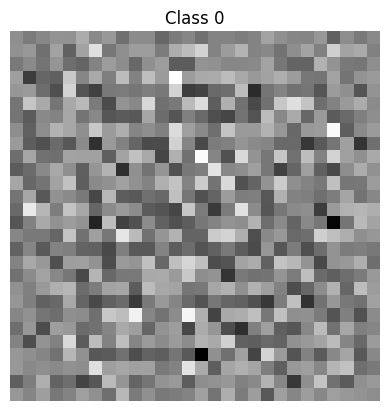

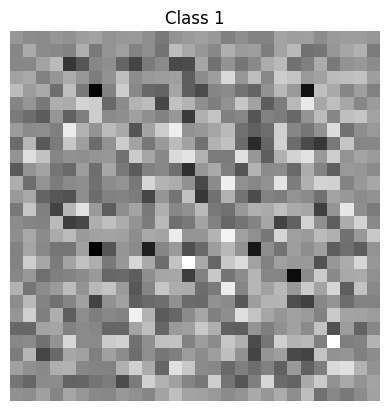

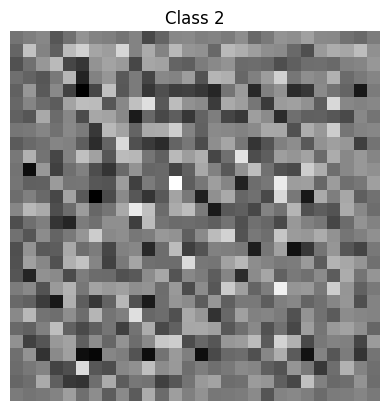

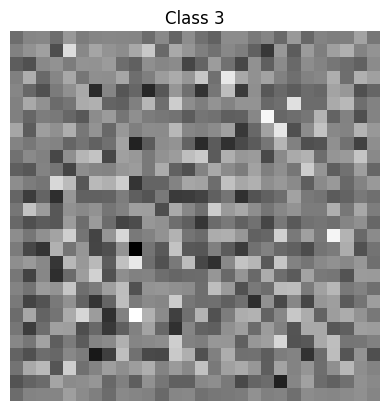

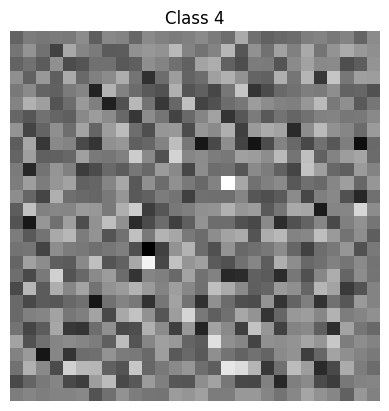

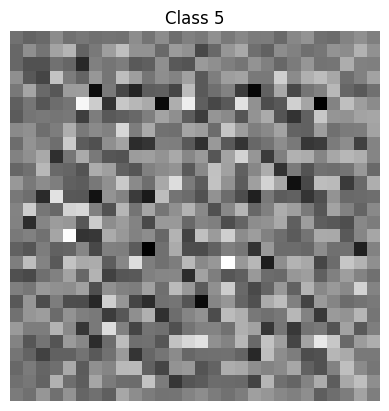

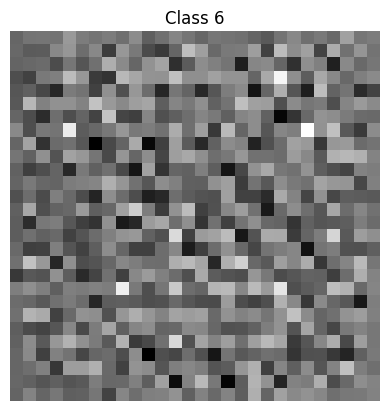

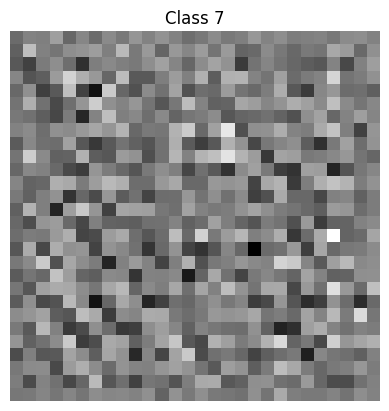

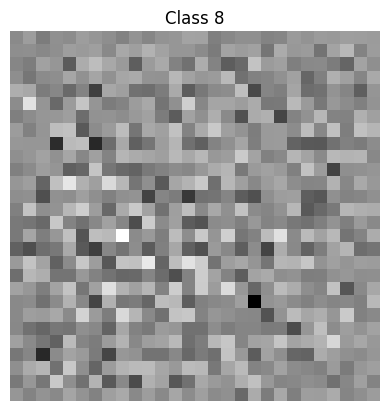

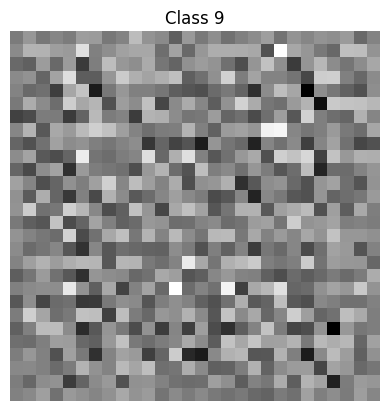

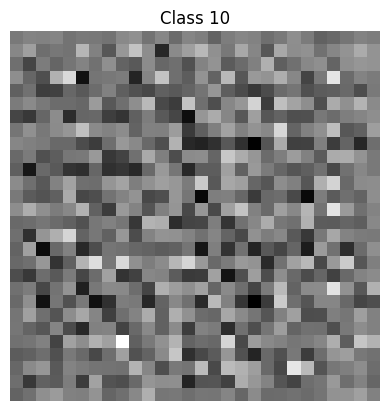

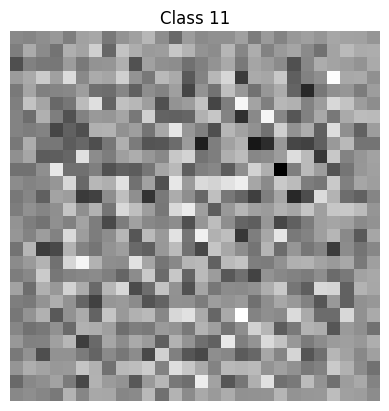

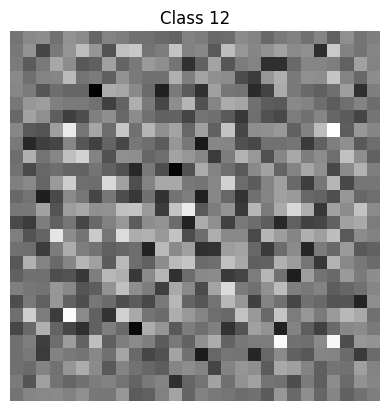

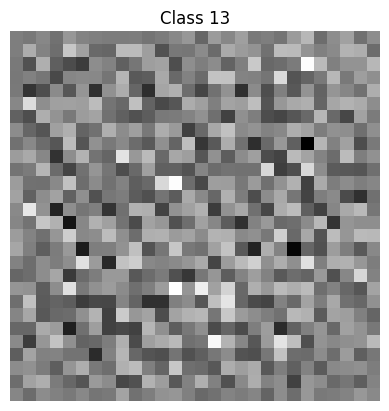

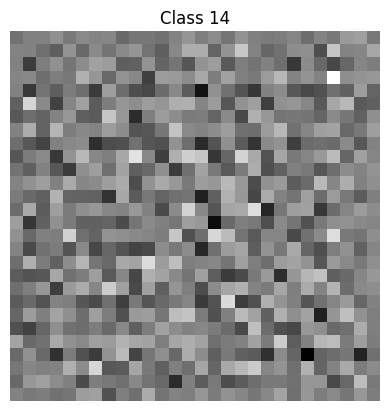

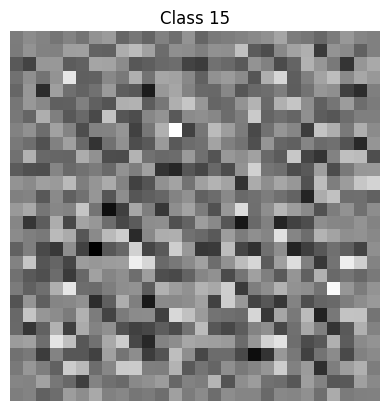

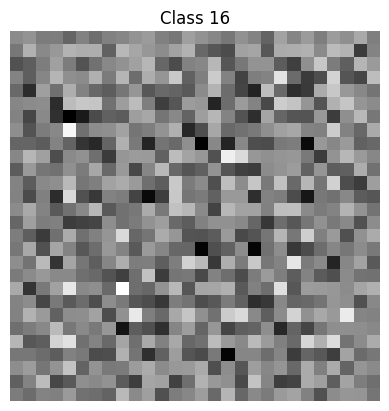

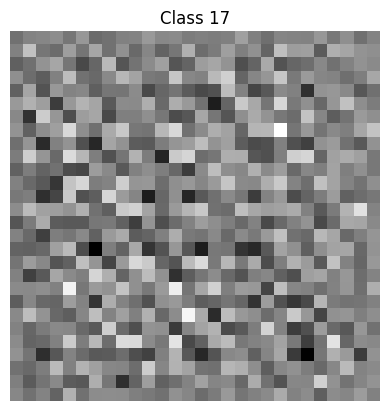

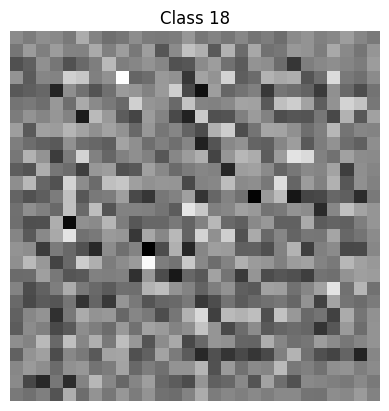

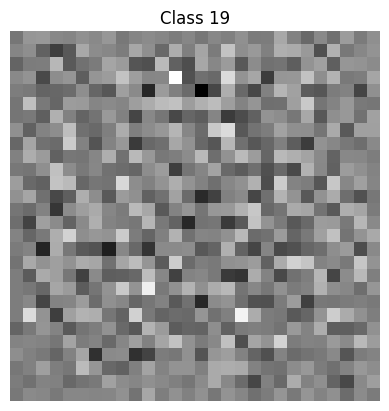

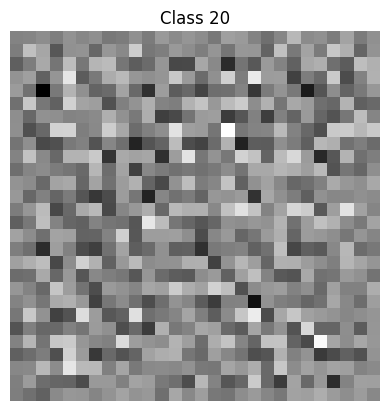

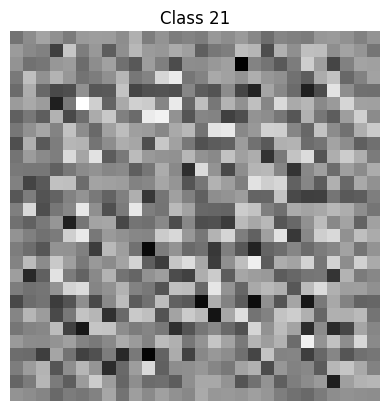

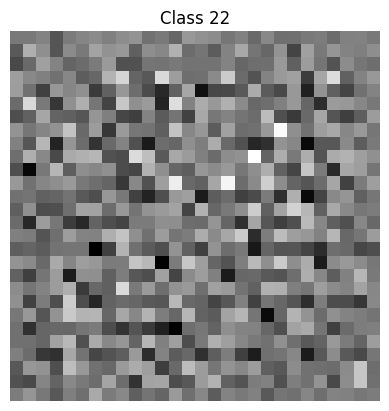

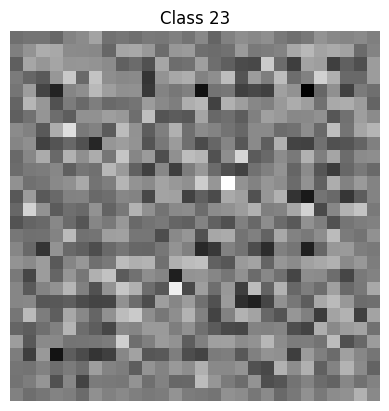

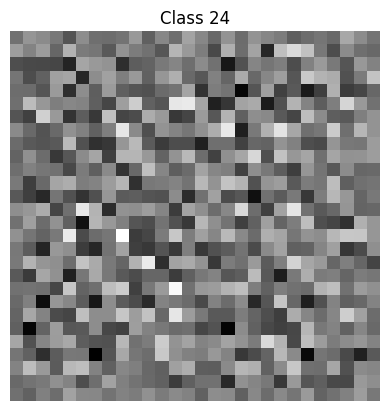

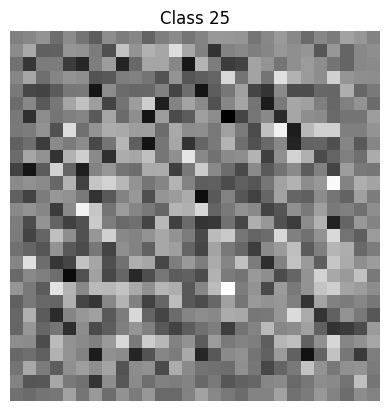

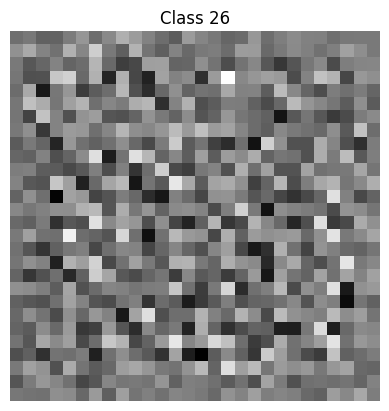

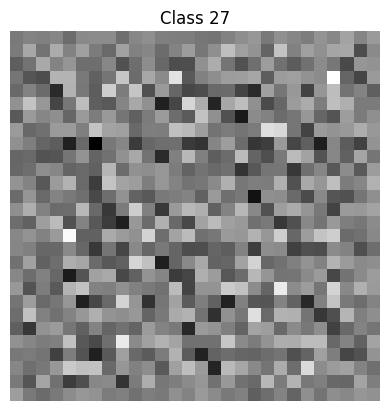

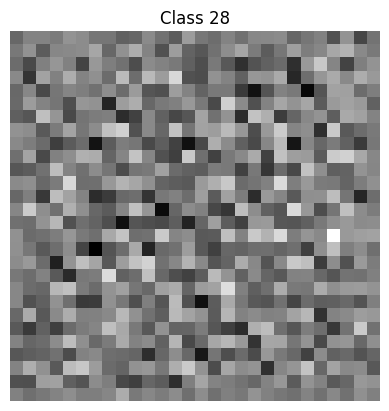

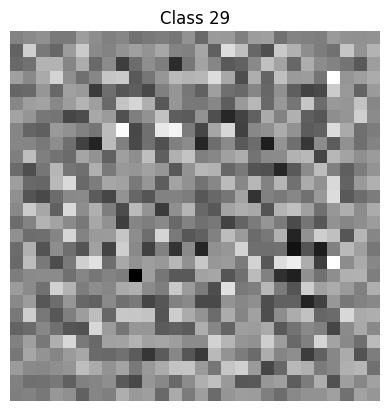

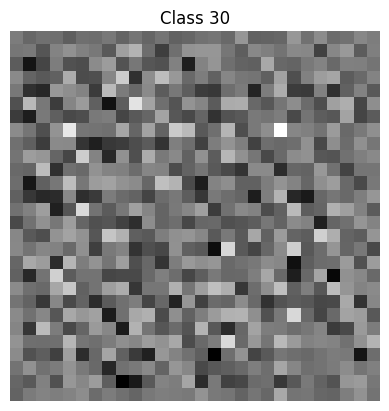

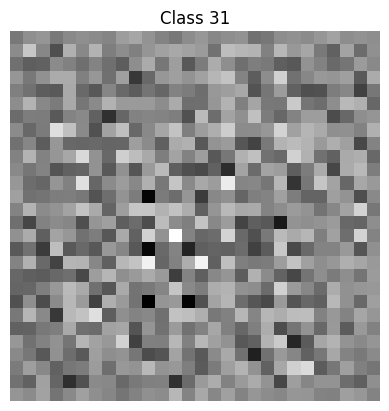

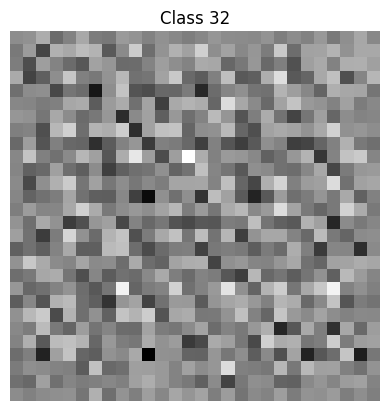

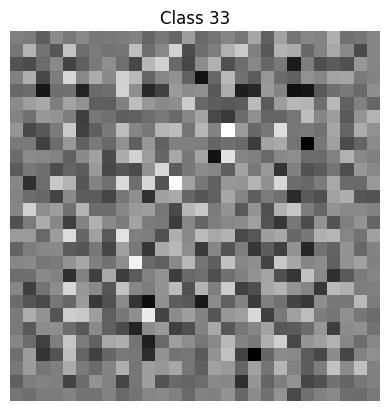

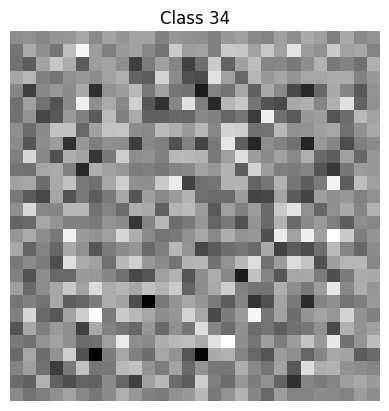

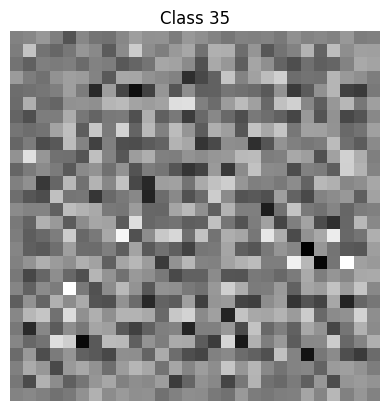

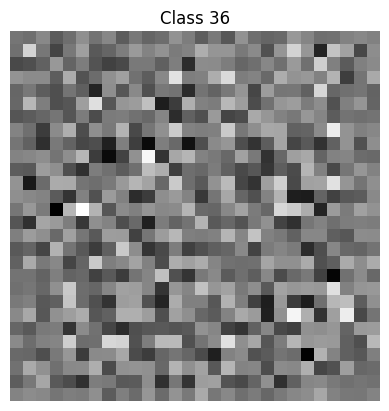

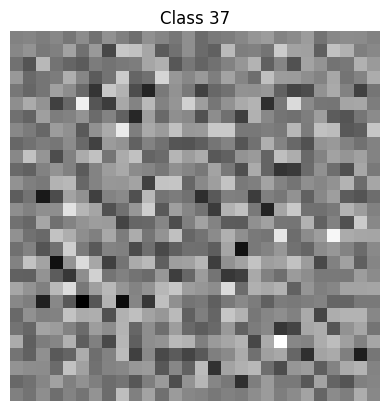

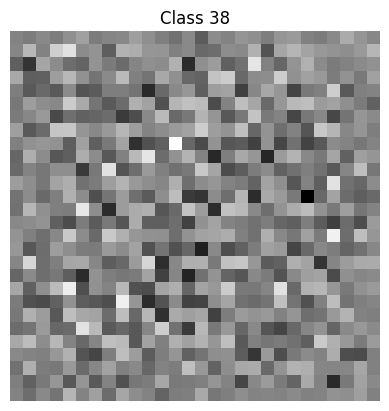

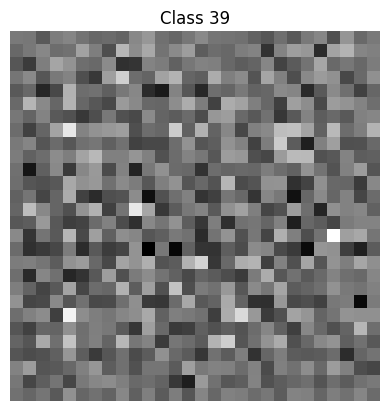

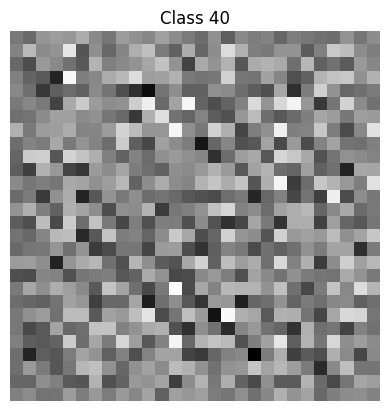

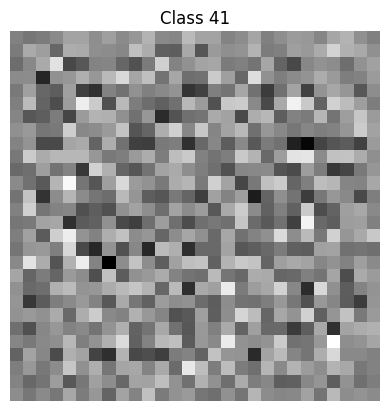

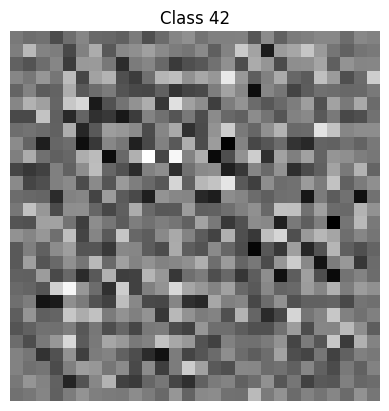

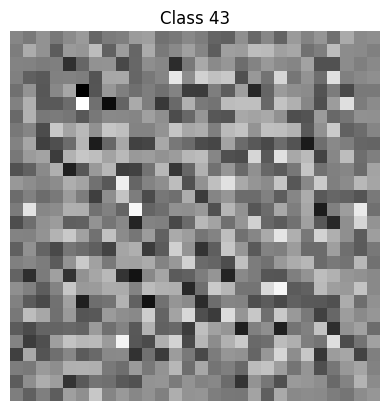

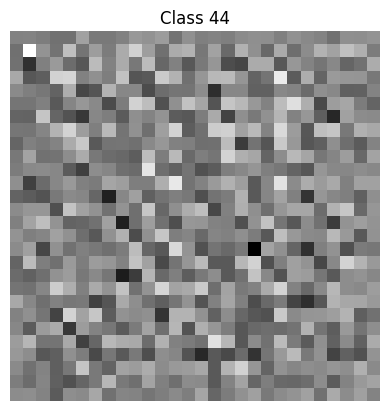

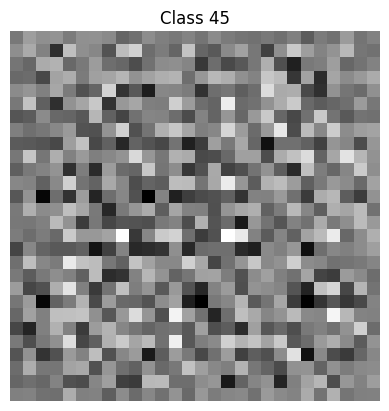

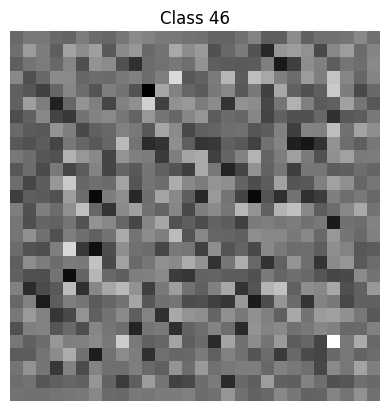

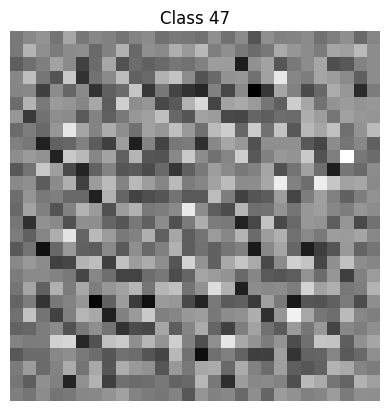

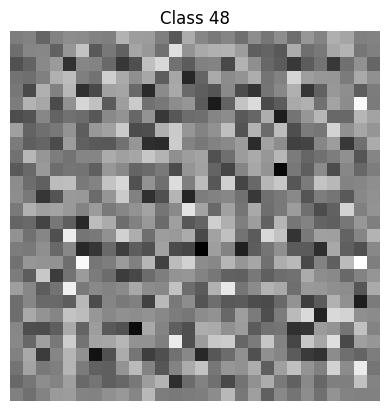

In [12]:
import matplotlib.pyplot as plt

generator.eval()
latent_dim = 100
num_classes = 49

for i in range(num_classes):
    z = torch.randn(1, latent_dim, 1, 1).to(device)
    label = torch.tensor([i], dtype=torch.long).to(device)

    with torch.no_grad():
        fake_img = generator(z, label).cpu()

    fake_img = fake_img.squeeze().numpy()
    plt.imshow(fake_img, cmap='gray')
    plt.axis('off')
    plt.title(f'Class {i}')
    plt.show()

In [13]:
def weights_init_xavier(m):
    """Инициализация Ксавье"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        init.constant_(m.bias.data, 0)

In [14]:
generator.apply(weights_init_xavier)

ConditionalGenerator(
  (label_emb): Embedding(49, 49)
  (model): Sequential(
    (0): ConvTranspose2d(149, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Tanh()
  )
)

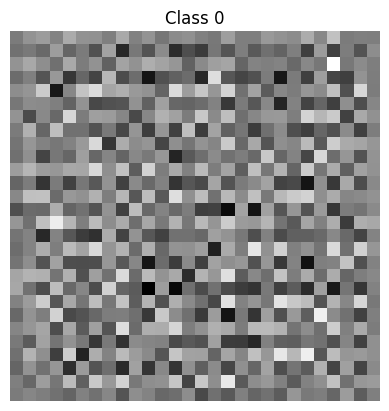

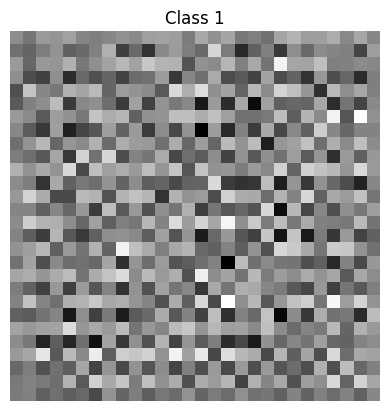

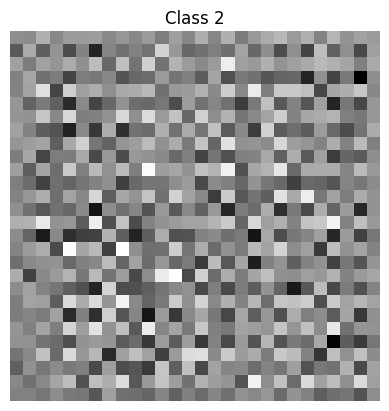

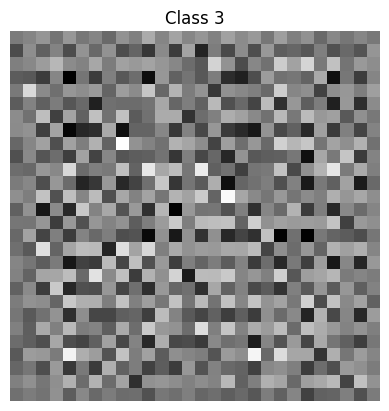

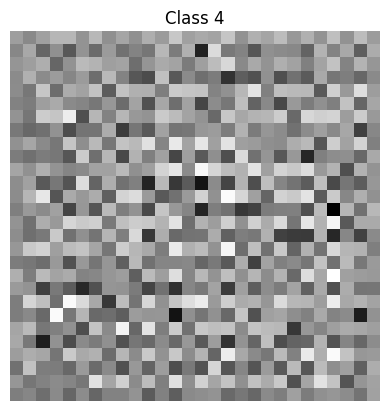

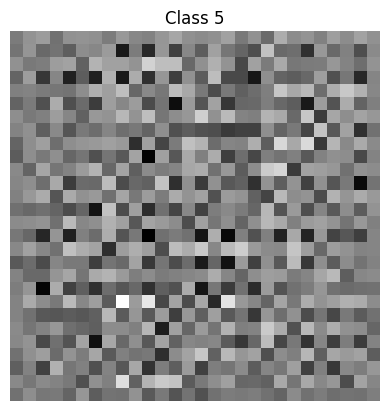

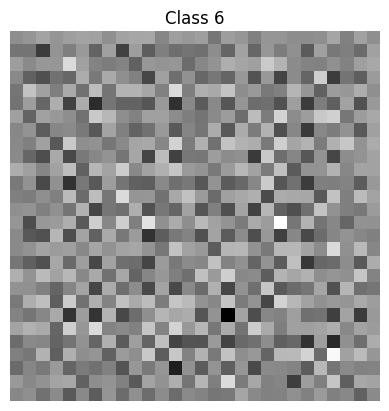

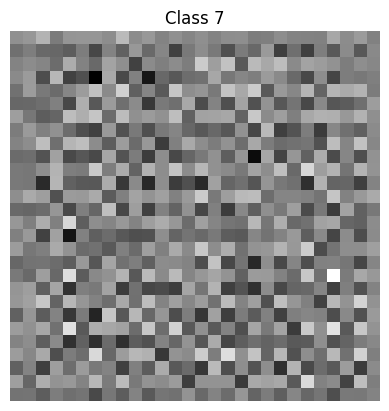

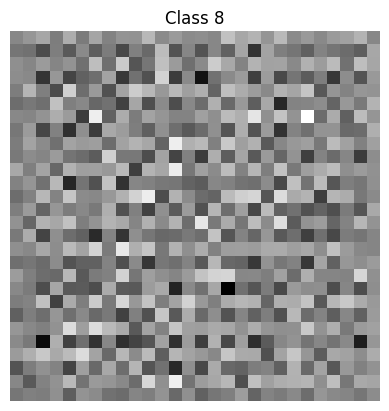

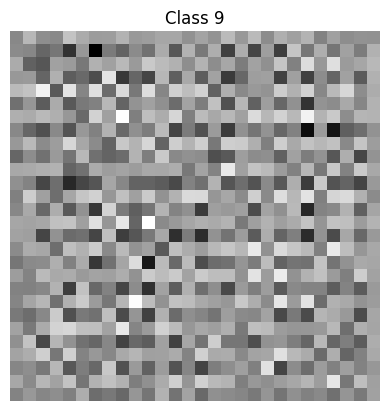

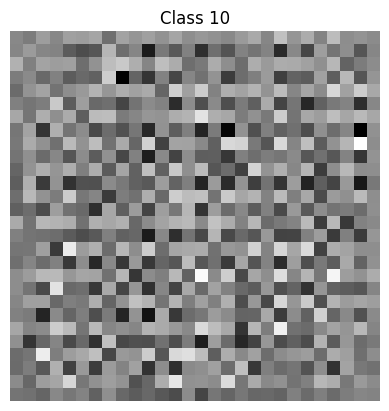

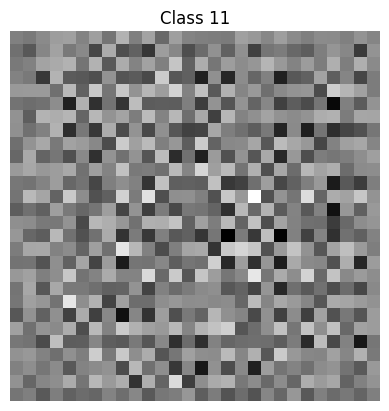

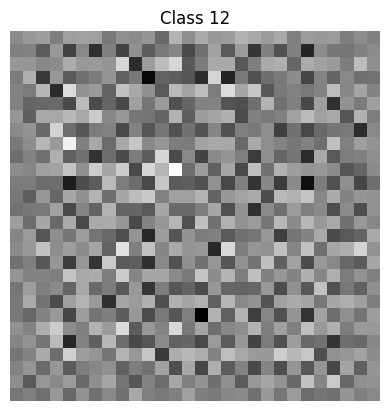

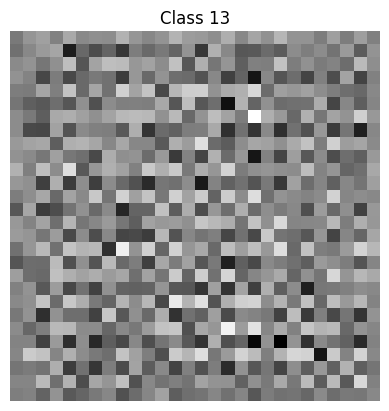

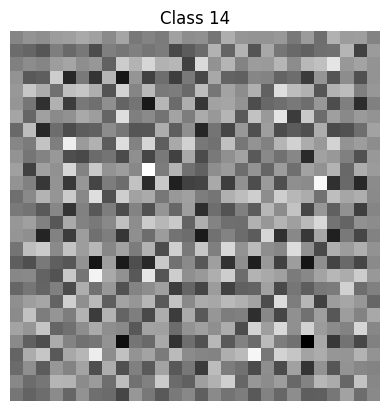

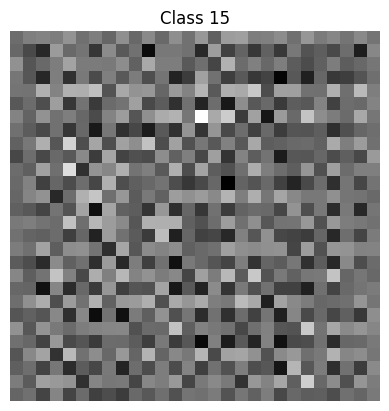

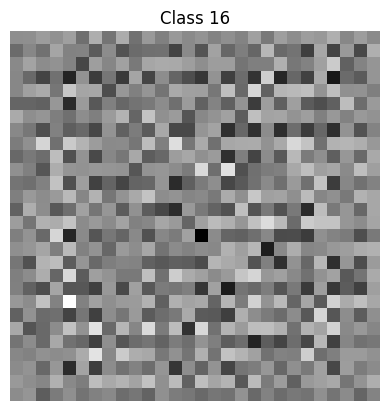

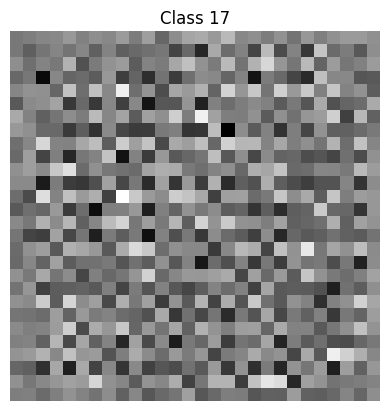

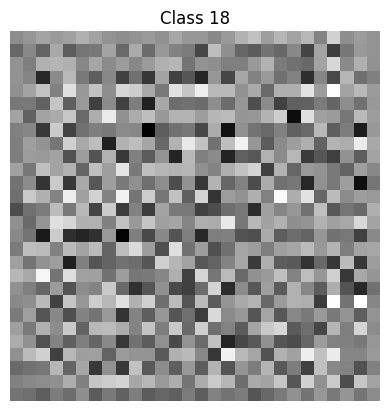

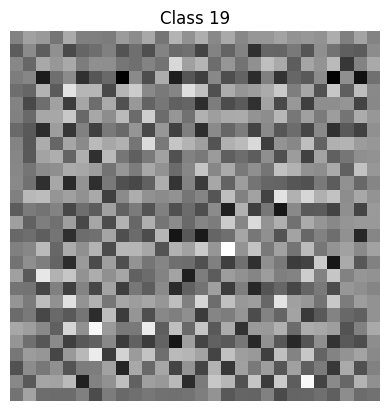

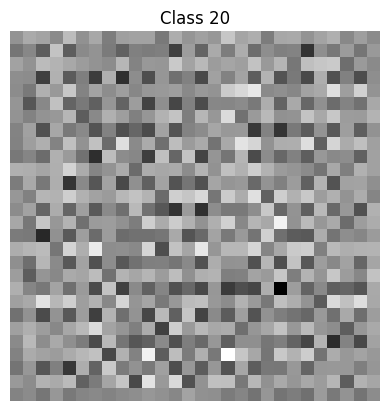

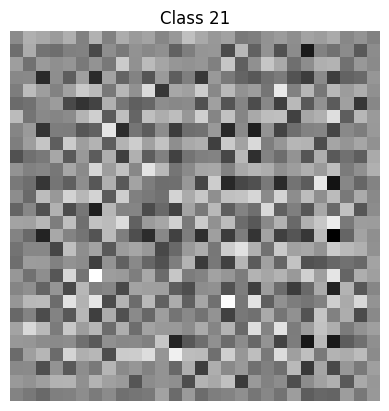

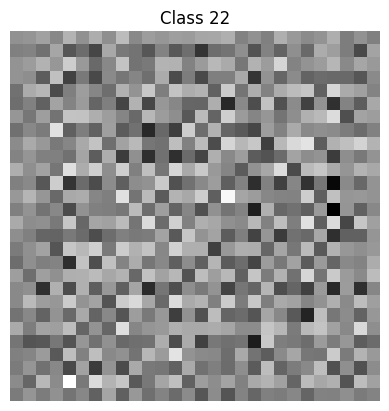

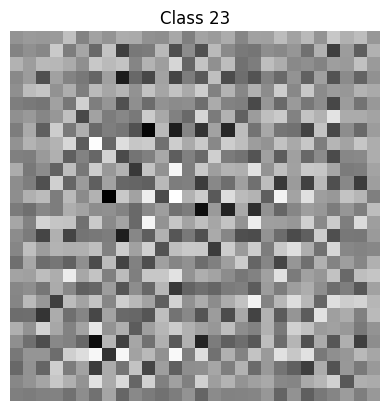

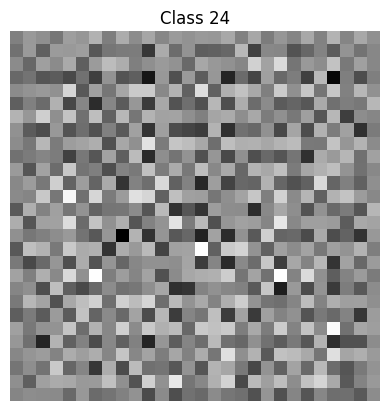

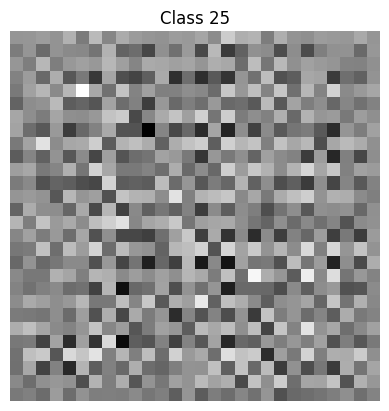

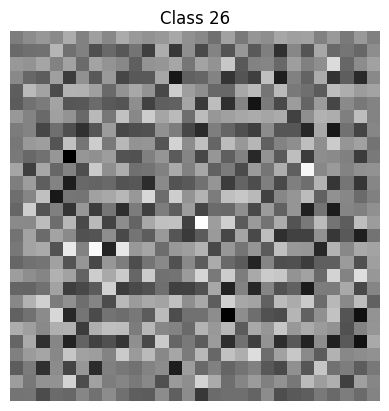

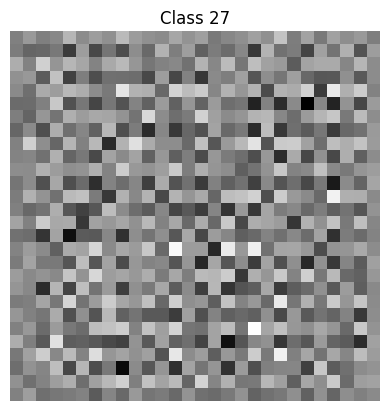

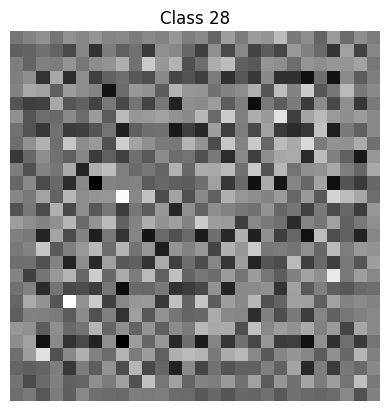

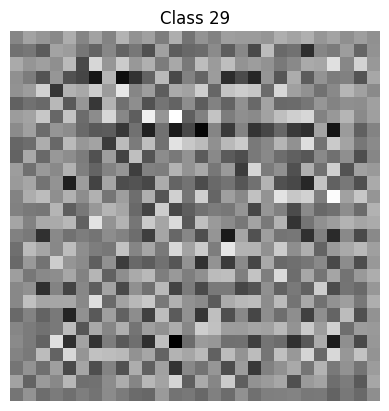

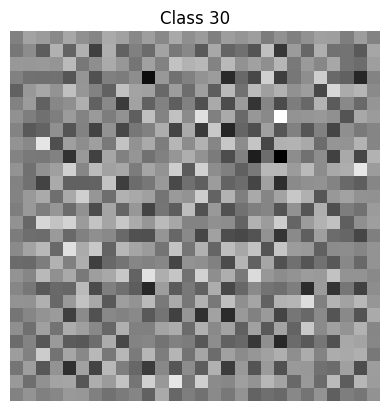

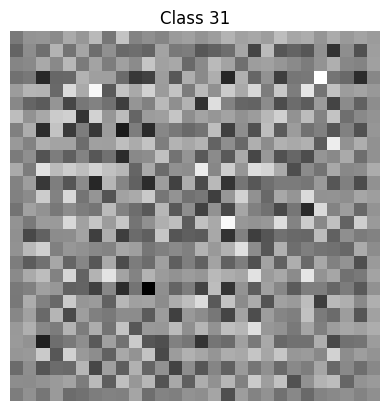

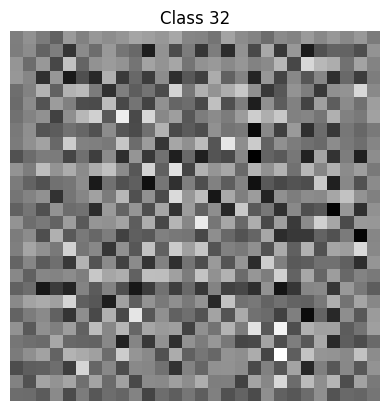

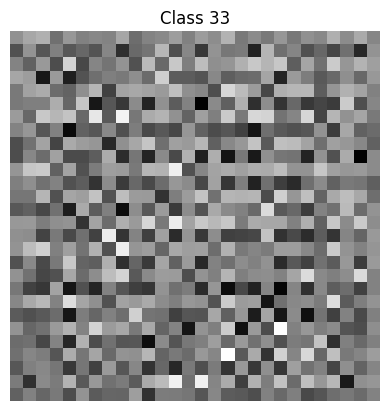

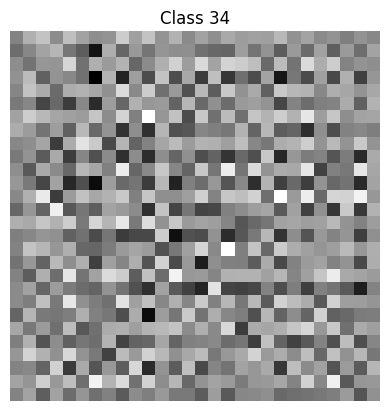

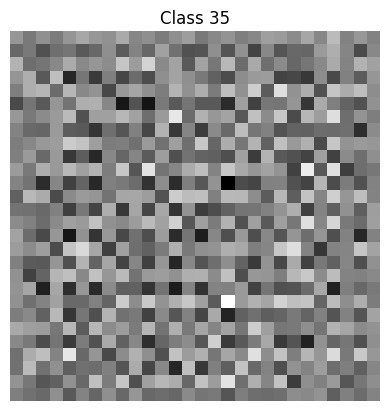

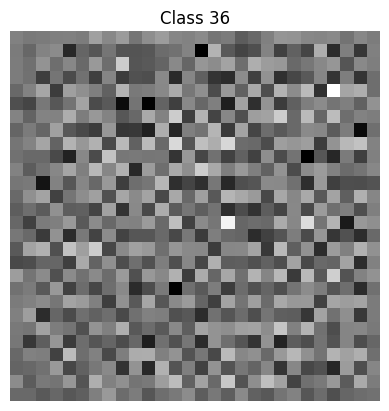

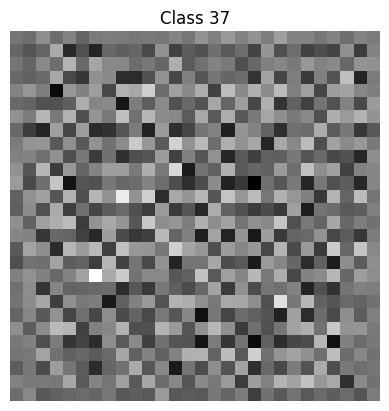

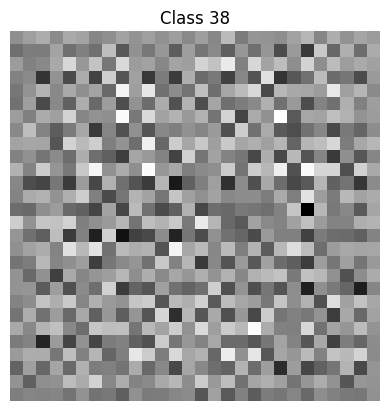

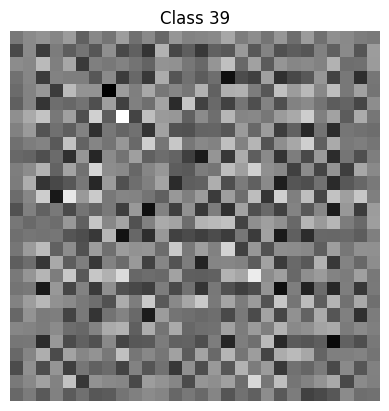

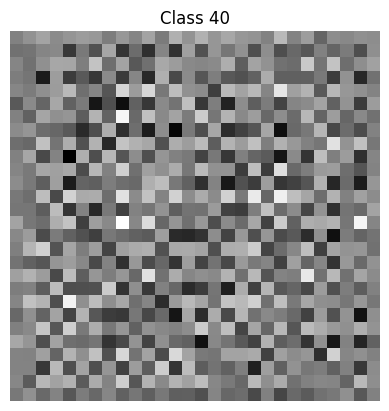

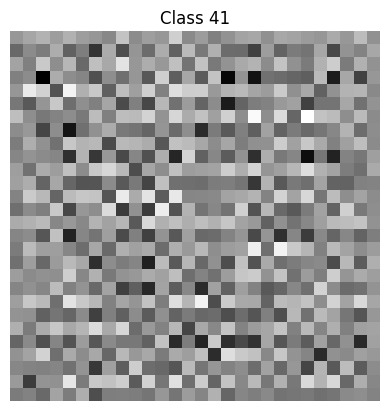

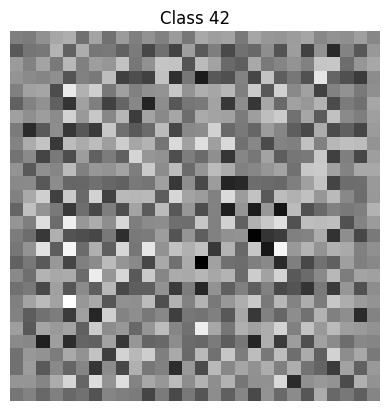

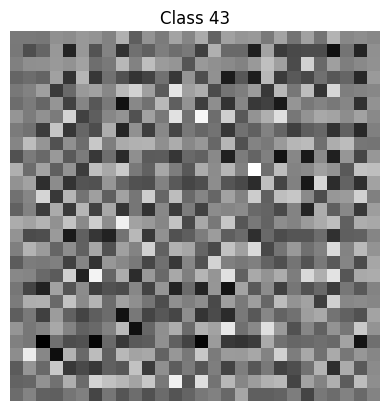

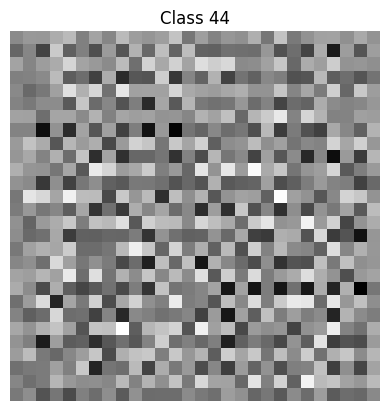

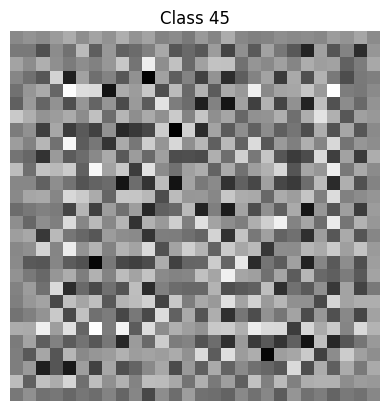

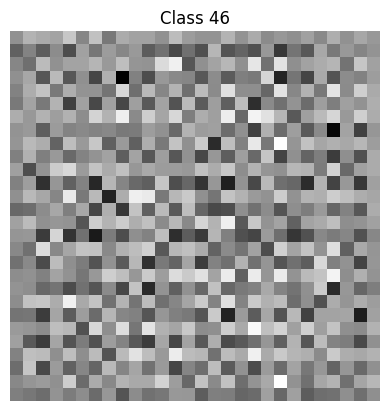

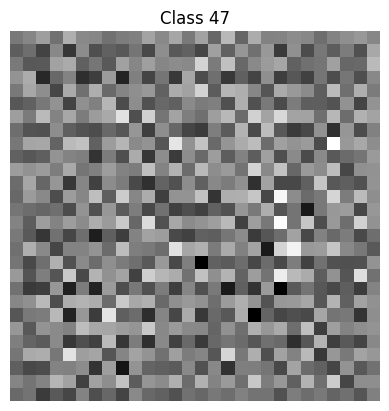

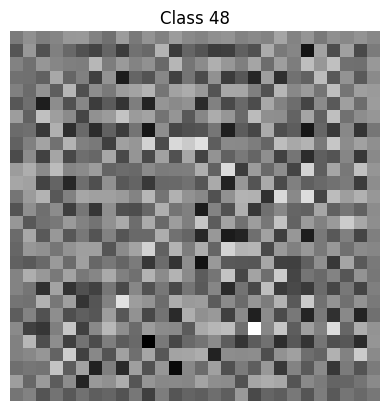

In [15]:
generator.eval()
latent_dim = 100  # Make sure this matches your trained model
num_classes = 49

for i in range(num_classes):
    z = torch.randn(1, latent_dim, 1, 1).to(device)
    label = torch.tensor([i], dtype=torch.long).to(device)

    with torch.no_grad():
        fake_img = generator(z, label).cpu()

    fake_img = fake_img.squeeze().numpy()
    plt.imshow(fake_img, cmap='gray')
    plt.axis('off')
    plt.title(f'Class {i}')
    plt.show()

Малое количество эпох в тренировочном цикле, конечно, не позволяет сделать достаточно полные выводы, однако визуализации изображений, полученных генераторами с разной инициализацией различаются. Вероятно, разная инициализация влияет на качество и разнообразие генерируемых изображений. Интересно также и то, что пиксели изображений при применении инициализации стали более разнообразными и гармоничными по балансу черного и белого на изображении. Вероятно, мы можем говорить об улучшении генерируемого результата при применении инициализации.

# **Ответы на вопросы теоретического блока.**

**1.) Чем отличается Conditional GAN от обычного GAN? Объясните, как вводится условная информация в генератор и дискриминатор?**

От GAN Conditional GAN отличается тем, что Conditinal GAN тренируются на данных с метками и позволяет генерировать изображения, принадлежащие к определённому классу, в то время как GAN просто генерирует случайные изображения. Условная информация в такой вид GAN подается как дополнительный input-layer. Generator принимает на вход шум(z), который помогает генерировать новые изображения, и сама метка класса. Каждая метка проходит через Embeeding, где становится плотным вектором, который потом объединяется с шумом в целях рандомизации. Затем этот вектор проходит через всю нейронную сеть. Discriminator получает изображение из реальных данных и условную метку у.

**2.) Почему обучение GAN может быть нестабильным, и какие техники помогают стабилизировать процесс?**

GAN состоит из двух нейросетей: генератора и дискриминатора. Динамическая тренировка двух конкурирующих нейросетей как раз и приводит к нестабильности при обучении GAN. Постоянное изменение характера оптимизации может привести к тому, что модели могут не сойтись. Генератор начинает закливаться в генерации конкретных примеров вместо нахождения точки равновесия(режим отказа). Также существует возможность возникновения коллапса - режима, при котором генератор учится отображать несколько разных входных значений z в одну и ту же выходную точку. Обучение GAN можно улучшить посредством использования сбалансированной архитектуры, контроля скорости обучения, адаптации функции потерь, добавления шума.

**3.) Какую роль играет латентное пространство в генерации изображений? Как условная информация влияет на него в CGAN?**

Латентное пространство помогает разнообразить генерацию, Позволяет модели изучать скрытые закономерности данных без явного кодирования признаков, тем самым упрощает обучение, а также вносит интерполируемость, которая делает генерируемые изображения более разнообразными и плавными при переходе от одного класса к другому.

**Влияние случайной инициализации**
Случайная инициализация весов сильно влияет на качество и стабильность обучения CGAN. Она определяет, как быстро и насколько хорошо модель будет сходиться.
